## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

## Get data
In TensorFlow this can be done via the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

In [30]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

# Identify Plant Diseases

We use the PlantVillage dataset [1] by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png) 

		Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab` 
- `Apple___Black_rot` 
- `Apple___Cedar_apple_rust` 
- `Apple___healthy` 
- `Blueberry___healthy` 
- `Cherry_(including_sour)___Powdery_mildew` 
- `Cherry_(including_sour)___healthy` 
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` 
- `Corn_(maize)___Common_rust_` 
- `Corn_(maize)___Northern_Leaf_Blight` 
- `Corn_(maize)___healthy', 'Grape___Black_rot` 
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)` 
- `Grape___healthy` 
- `Orange___Haunglongbing_(Citrus_greening)` 
- `Peach___Bacterial_spot` 
- `Peach___healthy` 
- `Pepper,_bell___Bacterial_spot` 
- `Pepper,_bell___healthy` 
- `Potato___Early_blight` 
- `Potato___Late_blight` 
- `Potato___healthy` 
- `Raspberry___healthy` 
- `Soybean___healthy` 
- `Squash___Powdery_mildew` 
- `Strawberry___Leaf_scorch` 
- `Strawberry___healthy` 
- `Tomato___Bacterial_spot` 
- `Tomato___Late_blight` 
- `Tomato___Leaf_Mold` 
- `Tomato___Septoria_leaf_spot` 
- `Tomato___Spider_mites Two-spotted_spider_mite` 
- `Tomato___Target_Spot` 
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus` 
- `Tomato___Tomato_mosaic_virus` 
- `Tomato___healthy`



We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Create a classes index file

We also want to know which class corresponds to which species and disease so we also create a `json` file which shows corresponding labels and class indices.

In [7]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [8]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [9]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [10]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [11]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [13]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/25
150/150 [==============================] - 84s 558ms/step - loss: 0.2392 - categorical_accuracy: 0.9258 - accuracy: 0.9258 - val_loss: 0.1896 - val_categorical_accuracy: 0.9425 - val_accuracy: 0.9425
Epoch 2/25
150/150 [==============================] - 80s 532ms/step - loss: 0.2373 - categorical_accuracy: 0.9262 - accuracy: 0.9262 - val_loss: 0.1840 - val_categorical_accuracy: 0.9394 - val_accuracy: 0.9394
Epoch 3/25
150/150 [==============================] - 92s 617ms/step - loss: 0.2275 - categorical_accuracy: 0.9278 - accuracy: 0.9278 - val_loss: 0.1782 - val_categorical_accuracy: 0.9403 - val_accuracy: 0.9403
Epoch 4/25
150/150 [==============================] - 82s 547ms/step - loss: 0.2339 - categorical_accuracy: 0.9223 - accuracy: 0.9223 - val_loss: 0.1609 - val_categorical_accuracy: 0.9525 - val_accuracy: 0.9525
Epoch 5/25
150/150 [==============================] - 77s 515ms/step - loss: 0.2297 - categorical_accuracy: 0.9219 - accuracy: 0.9219 - val_loss: 0.1643 - v

## Review the training process

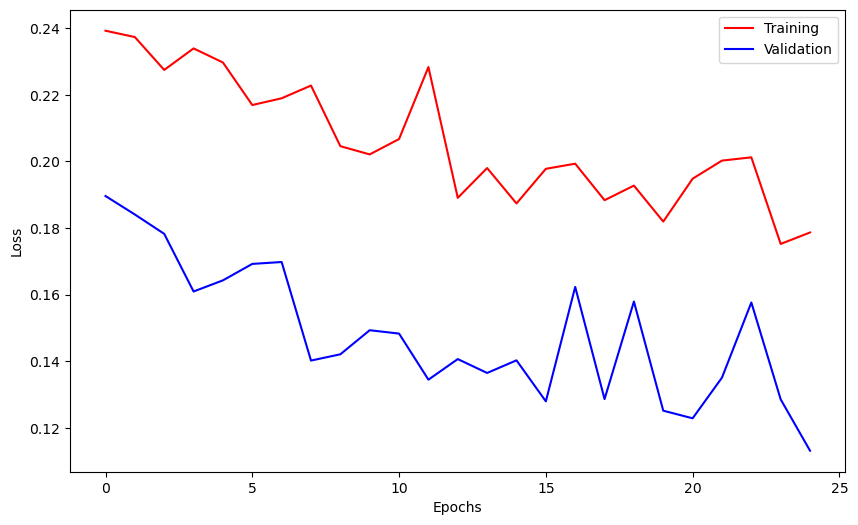

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

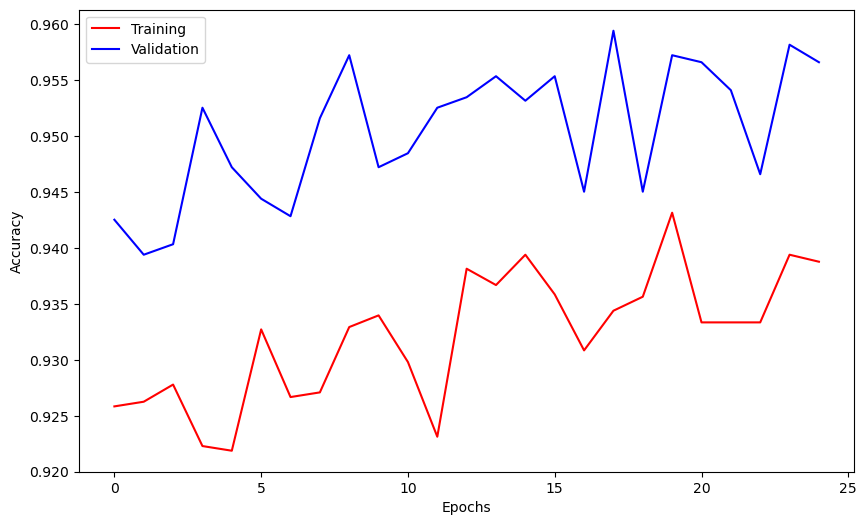

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [19]:
history.history


{'loss': [0.2392417937517166,
  0.23734024167060852,
  0.22746402025222778,
  0.23393160104751587,
  0.22969624400138855,
  0.21692365407943726,
  0.21895019710063934,
  0.22277532517910004,
  0.20456591248512268,
  0.20208998024463654,
  0.20671163499355316,
  0.22832898795604706,
  0.18904456496238708,
  0.1979958713054657,
  0.1873633712530136,
  0.19776637852191925,
  0.19930380582809448,
  0.188339501619339,
  0.19271929562091827,
  0.181917205452919,
  0.1947917491197586,
  0.2002364695072174,
  0.20121142268180847,
  0.17520232498645782,
  0.17864754796028137],
 'categorical_accuracy': [0.9258333444595337,
  0.9262499809265137,
  0.9277812838554382,
  0.9222916960716248,
  0.921875,
  0.9327083230018616,
  0.9266666769981384,
  0.9270833134651184,
  0.9329166412353516,
  0.9339583516120911,
  0.9297916889190674,
  0.9231250286102295,
  0.9381250143051147,
  0.9366666674613953,
  0.9393749833106995,
  0.9358333349227905,
  0.9308333396911621,
  0.934374988079071,
  0.935625016689

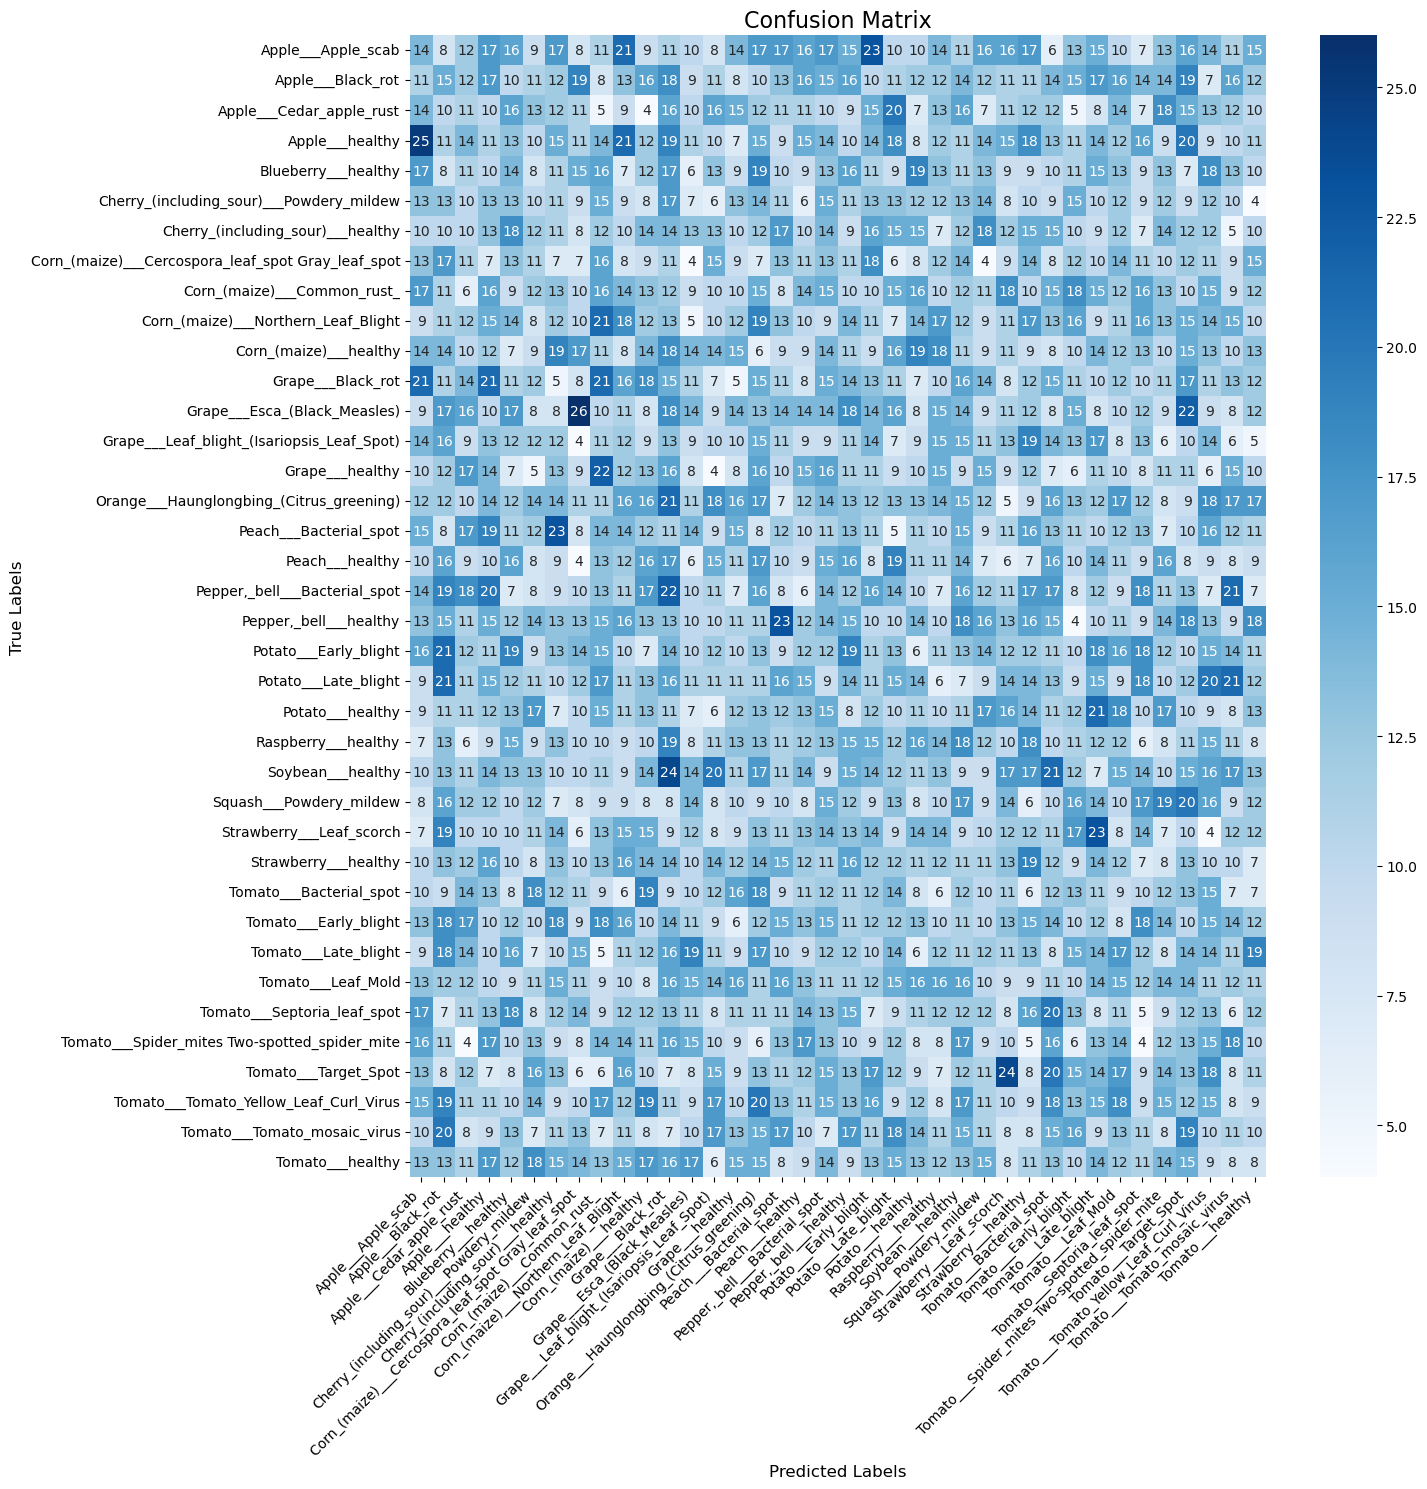

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_data.class_indices.keys())  # Class names

# Create a larger figure
plt.figure(figsize=(15, 15))

# Use seaborn for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)

# Adjust label and title settings
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
# Assuming 'history' is the result of model.fit()
highest_training_accuracy = max(history.history['accuracy'])
highest_validation_accuracy = max(history.history['val_accuracy'])

print(f"Highest Training Accuracy: {highest_training_accuracy:.4f}")
print(f"Highest Validation Accuracy: {highest_validation_accuracy:.4f}")

# Assuming 'history' is the result of model.fit()
lowest_training_loss = min(history.history['loss'])
lowest_validation_loss = min(history.history['val_loss'])

print(f"Lowest Training Loss: {lowest_training_loss:.4f}")
print(f"Lowest Validation Loss: {lowest_validation_loss:.4f}")


Highest Training Accuracy: 0.9431
Highest Validation Accuracy: 0.9594
Lowest Training Loss: 0.1752
Lowest Validation Loss: 0.1131


Found 17572 files belonging to 38 classes.
1/1 [==============================] - 0s 22ms/step


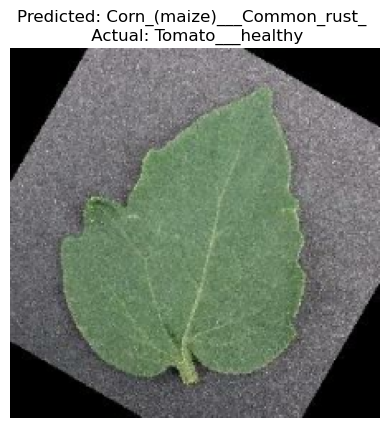

Actual Label: Tomato___healthy
Predicted Label: Corn_(maize)___Common_rust_


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming you are using image_dataset_from_directory for your test set
# and the path is already defined in your notebook
# test_dir = 'path_to_your_test_data'  # Update this with the actual test data path from your notebook

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Replace with your actual test directory
    image_size=(224, 224),  # Resize images to match model input size
    batch_size=1,  # We are taking one image at a time for prediction
    label_mode='int'  # Use integer labels
)

# Get the class names (the names of the disease types or plant species)
class_names = test_dataset.class_names

# Get a batch of images and labels
for img_batch, label_batch in test_dataset.take(1):  # Load one image from the test set
    img = img_batch[0]  # Get the first image from the batch
    true_label = label_batch[0].numpy()  # Get the corresponding label
    break  # Exit the loop after the first image

# Predict using the trained model
img_array = tf.expand_dims(img, 0)  # Add batch dimension
predictions = model.predict(img_array)  # Get predictions from the model
predicted_class = np.argmax(predictions, axis=1)  # Get the predicted class index

# Display the image with predicted and actual labels
plt.imshow(img.numpy().astype("uint8"))
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class[0]]} \n Actual: {class_names[true_label]}")
plt.show()

# Print Actual vs Predicted
print(f"Actual Label: {class_names[true_label]}")
print(f"Predicted Label: {class_names[predicted_class[0]]}")


## Save the model
We finally save the model in the standard TensorFlow 2 SavedModel format.

In [24]:
model.save('plant_disease')

## Converting to tflite Model

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)